In [20]:
import os
from math import ceil
from itertools import repeat
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)  # if you need to view less rows, comment
# pd.set_option('display.max_rows', None)  # if you need to view more rows, uncomment
idx_slice = pd.IndexSlice

In [21]:
def split_biorad_chromatogram_dataframe_to_unique_runs(df):
    dfs = [df.loc[:, idx_slice[run, :]] for run in df.columns.levels[0].to_list()]
    for df in dfs:
        df.columns = df.columns.remove_unused_levels()
    return dfs

In [40]:
def plot_chromatograms(sec_runs, chromatogram_keywords=None, only_280=True, volume_is_column=False, 
                       stack_figures=False, overlap_chromatograms=False, annotate=True,
                       fractions=False, fraction_start=None, fraction_end=None, fraction_size=0.5,
                       max_y=None, min_y=None, max_x=None, min_x=None):

    figure_aspect_ratio = (15, 5)
    fig = plt.figure(figsize=figure_aspect_ratio)
    
    if not chromatogram_keywords:
        chromatogram_keywords = []
#         plot = True
    else:
#         plot = False
        runs_of_interest = []
        for idx, run_df in enumerate(sec_runs):
            # check whether the particular chromatogram is the desired one based off of keywords
            df_name = run_df.columns.levels[0][0]  # level zero, label zero
            df.columns.levels[0].to_list()
#             print(df_name)
            for keyword in chromatogram_keywords:
                if keyword in df_name:
                    runs_of_interest.append(run_df)
                    break
    #         if plot and chromatogram_keywords:  # keyword has been found, reset trigger for next iteration
    #             plot = False
    #         elif not chromatogram_keywords :  # keywords weren't requested, maintain True
    #             plot = True
    #         else:  # keyword hasn't been found, skip this plot
    #             continue
        sec_runs = runs_of_interest
        print('found %d chromatograms with the keyword(s) %s: \n%s' %
              (len(sec_runs), ', '.join(chromatogram_keywords), '\n'.join([run_df.columns.levels[0][0] for idx, run_df in enumerate(sec_runs)])))
              
    if overlap_chromatograms:
        axis = fig.subplots(1, 1, sharex=True)
        axes = [axis for _ in range(len(sec_runs))]
    elif stack_figures:
        figs = [plt.figure(figsize=figure_aspect_ratio) for _ in range(len(sec_runs))]
        axes = [fig.subplots(1, 1, sharex=True) for fig in figs]
    else:
        axes = fig.subplots(len(sec_runs), 1, sharex=True)
    
    for idx, run_df in enumerate(sec_runs):
        df_name = run_df.columns.levels[0][0]  # level zero, label zero
        uv_columns = []
        volume = None
        for column in run_df.columns.levels[-1].to_list():
            if column.startswith('UV'):
                if column.endswith('_volume'):
                    volume = column
                elif only_280:
                    if '280 nm' in column:
                        uv_columns.append(column)
                    else:
                        continue
                else:
                    uv_columns.append(column)
                    

        if volume_is_column and volume:      
            selected_columns = [volume] + uv_columns
        else:
            selected_columns = uv_columns
        
#         volume, uv_columns = chromatogram_graph_data[idx] # [vol_idx], chromatogram_graph_data[idx][uv_idx]
        run_df.columns = run_df.columns.remove_unused_levels()  # .unique()
        formatted_df = run_df.loc[:, idx_slice[:, selected_columns]].droplevel(0, axis=1)
        # grab first level, first (and only index)
        # df_title = run_df.columns.levels[0].unique()  # Doesn't work as grabs old levels from original DF
        df_title = run_df.columns.get_level_values(0).unique()
        if len(df_title) != 1:
            print('Error, multiple headers detected in dataframe %s!\n%s' % (df_title, run_df.head()))
            break
        # formatted_df = formatted_df[formatted_df[volume] > 0.007]
        # format the volume as the dependent variable
        if volume_is_column:      
            formatted_df.index = formatted_df[volume]
            formatted_df.drop(volume, axis=1, inplace=True)
        formatted_df.index.name = 'Volume'
        
        # format column names to be pretty
        formatted_df.columns = formatted_df.columns.map(dict(zip(formatted_df.columns, 
            map(str.strip, 
                map(str.strip, 
                    map(str.replace, 
                        map(str.replace, formatted_df.columns, repeat('_mAU'), repeat('')),
                        repeat('UV'), repeat('')), 
                    repeat('1234567890 ')), 
                repeat('()')))))
#         formatted_df.plot(title=df_title[0])
        axes[idx].plot(formatted_df.index.values, formatted_df.values, label=df_name) # formatted_df.columns)
        axes[idx].legend()
#         axes[idx].set_xlim(0, None)
        if fractions:
            if not annotate:
                continue
            if not fraction_start:
                fraction_start = 0.
            if not fraction_end:
                fraction_end = formatted_df.index[-1]
            number_of_fractions = (fraction_end - fraction_start) / fraction_size
            fraction_start_volumes = [fraction_start + (fraction_size * fraction) for fraction in range(ceil(number_of_fractions))]
            axes[idx].vlines(fraction_start_volumes, 0, 1, transform=axes[idx].get_xaxis_transform(), label='Fractions', colors=['#cccccc' if idx % 2 == 1 else '#000eee' for idx, _ in enumerate(fraction_start_volumes)])
            max_height = formatted_df.max()
            for f_idx, volume in enumerate(fraction_start_volumes, 1):
#                 axes[idx].annotate(f_idx, xy=(volume, max_height),
                axes[idx].annotate(f_idx, xy=(volume, 1),  xycoords=('data', 'axes fraction'), textcoords=('data', 'axes fraction') , # xycoords=axes[idx], textcoords=axes[idx],  #   # xytext=(-3, np.sign(l)*3),
                                   horizontalalignment='left', verticalalignment='top')
#                 matplotlib.patches.Rectangle(xy, width, height, angle=0.0, **kwargs)
            if overlap_chromatograms:
                annotate = False
#         if stack_figures:
#             plt.show()
#     if not stack_figures:
    if min_y is None:
        min_y = 0
        
    if min_x is None:
        min_x = 0
    
    for idx, axis in enumerate(axes):
        axes[idx].set_ylim(min_y, max_y)
        axes[idx].set_xlim(min_x, max_x)
        
    plt.show()

## Collect chromatograms

from a directory

In [23]:
file_directory = '/home/kmeador/SEC'

In [24]:
analysis_files = [os.path.join(file_directory, file) for file in os.listdir(file_directory) if file.endswith('.csv')]

from file(s)

In [6]:
file_location = '/home/kmeador/SEC' # escher
# file_location = '/home/kylemeador' # powerpanda
file_directories = repeat(file_location)
file_names = ['123021_T33_G8_F3_F9_450ul_strait_elution',
#               '',
             ]

In [7]:
def create_file_path(file_name, base_directory=None, extension='.csv'):
    return os.path.join(base_directory if base_directory else '', '%s%s' % (file_name, extension))

In [8]:
analysis_files = list(map(create_file_path, file_names, file_directories))

## Check DataFrame columns and values

Ensure that the csv file has properly formatted headers. If there are commas in your chromatogram name, the export and load process may be corrupted.

#### for datasets that are exported with volumes for every measurement

In [9]:
volume_is_index = False
# sec_data_df = pd.read_csv(analysis_file, header=[0,1])
sec_data_dfs = [pd.read_csv(analysis_file, header=[0,1]) for analysis_file in analysis_files]

#### For datasets that are exported with normalized volumes (every measurement is indexed to the same volume)

In [25]:
volume_is_index = True
# sec_data_df = pd.read_csv(analysis_file, header=[0,1], index_col=0)
sec_data_dfs = [pd.read_csv(analysis_file, header=[0,1], index_col=0) for analysis_file in analysis_files]

Check if the data is formatted as requested

In [26]:
sec_data_dfs[0].head()

,2C 100ul SEC 2,8C 100ul SEC 2
X_Axis_volume,UV3 (280 nm)_mAU,UV3 (280 nm)_mAU
-0.997238,NaN,0.0
-0.996320,0.0,0.0
-0.995754,0.0,0.0
-0.994992,0.0,0.0
-0.994192,NaN,NaN


In [27]:
run_titles = []
for df in sec_data_dfs:
    run_titles.extend(df.columns.levels[0].to_list())
print('The following chromatograms are available for analysis: \n%s' % '\n'.join(run_titles))

The following chromatograms are available for analysis: 
2C 100ul SEC 2
8C 100ul SEC 2
2022/1/20_E12_Superose6_MGRCG
2022/1/20_G4_MGRCG
T33_H8_fraction200mM_conc4_5ml_to170ul
P432_2C_450ul_conc_elution
P432_8C_400ul_conc_elution
T33_F9_conc_elution_200mM_and_300mM_1.25ml
T33_G8_Conc_elution_from_211231_900ul
T33_H7_conc_elution200andHigher_1.05ml
T33_F5_200mM_elution_conc_250ul
T33_F5_concentrated_elution_150mM_200ul
T33_G4_elution_fraction1_strait_460ul
T33_H4_strait_elution200mM_480ul_fix_bad_collect
4E Run01
T33_E12_all_conc_fractions_spinDownInsol_220213Prep_240ul_run3
T33_E12_all_conc_fractions_spinDownInsol_prep220213_run2_400ul
T33_E12_all_fractions_concentrated_490ul
T33_E12_conc_elutions_spinDownInsol440ul
T33_E12_elution_fraction1_5ml_conc_to270ul_LOBSTR
T33_F3_elution_fraction1_strait_from220213_490ul
T33_F3_strait_elution2_220213_prep_490ul
T33_F3_IonEx_conc_50ul_sample_sent_toSSRL
T33_G8_50ul_Sent_to_SSRL
T33_F3_conc_elution_conc_SEC_mishap_200ul_real
T33_F5_elution_strait

In [29]:
sec_runs = []
for df in sec_data_dfs:
    sec_runs.extend(split_biorad_chromatogram_dataframe_to_unique_runs(df))

## Plotting Options

Include specific keywords for plots to include using strings from the title of each run

In [49]:
chromatogram_keywords = [
                         'E12', 
#                          'spinDownInsol',
#                          '_fraction1_strait_from22021'
                        ]

How should plots be generated?

In [50]:
only_plot_A280 = True # False # 
# overlap_chromatograms = True # False #   | Will take priority over stack figures, so if True, then regardless, the chromatograms will stack
overlap_chromatograms = False 
stack_figures = True # False # 
plot_fractions = True # False # 
fraction_size = 0.5
fraction_start = 8.068
fraction_end = 25.0
# plotting options
max_y = 200
min_y = None
max_x = None
min_x = None

found 9 chromatograms with the keyword(s) E12: 
2022/1/20_E12_Superose6_MGRCG
T33_E12_all_conc_fractions_spinDownInsol_220213Prep_240ul_run3
T33_E12_all_conc_fractions_spinDownInsol_prep220213_run2_400ul
T33_E12_all_fractions_concentrated_490ul
T33_E12_conc_elutions_spinDownInsol440ul
T33_E12_elution_fraction1_5ml_conc_to270ul_LOBSTR
T33_E12_elution_concentrated_240ul
T33_E12_elution_0.9ul_concentrated
T33_E12_220121_conc_220120elution_fraction1_RCG_390ul


<Figure size 1500x500 with 0 Axes>

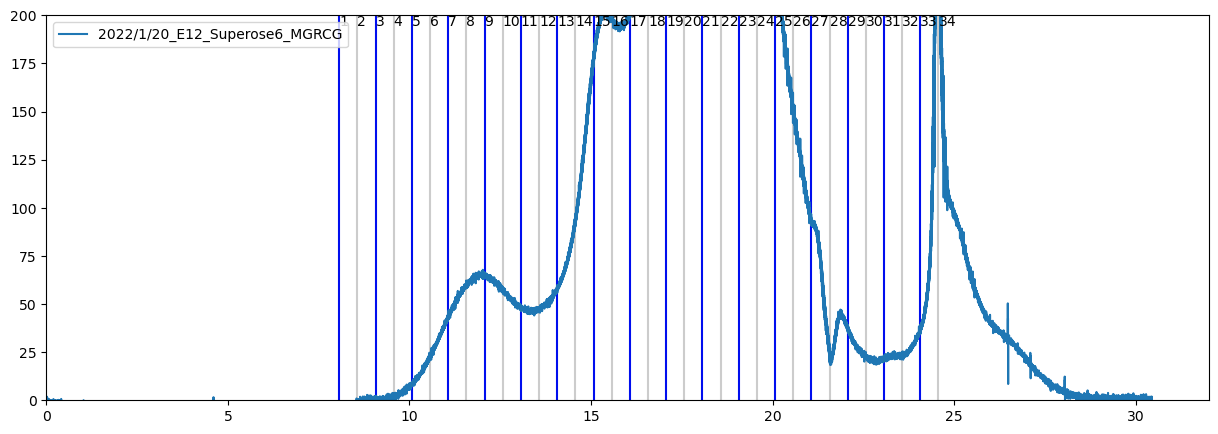

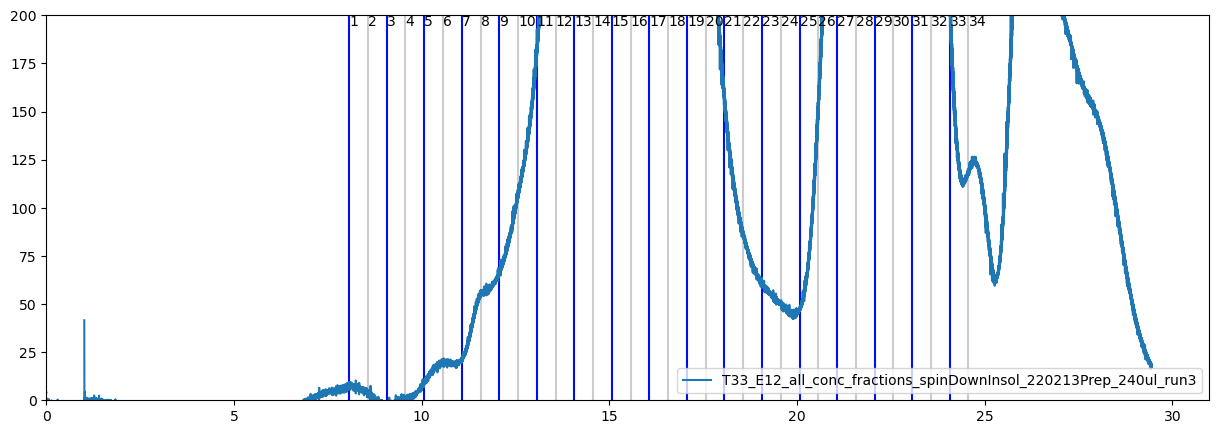

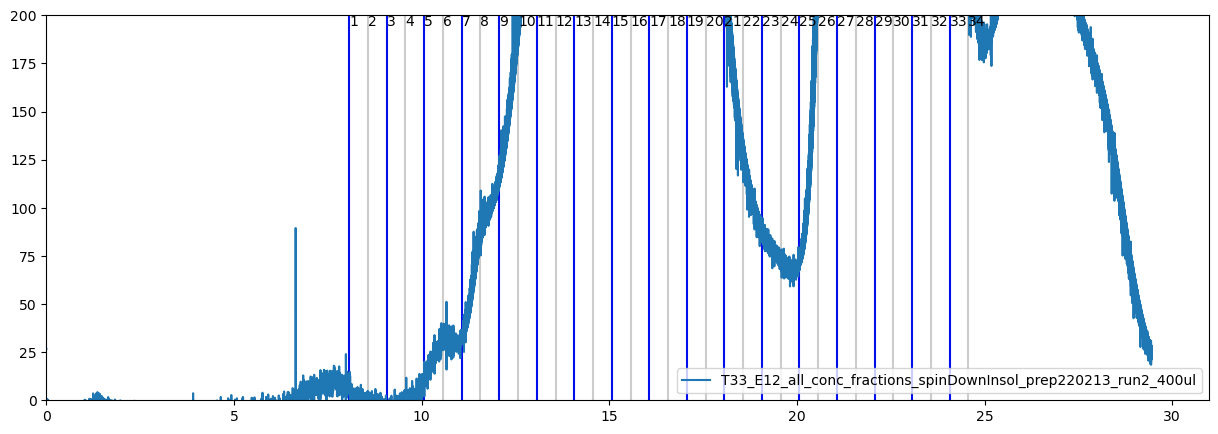

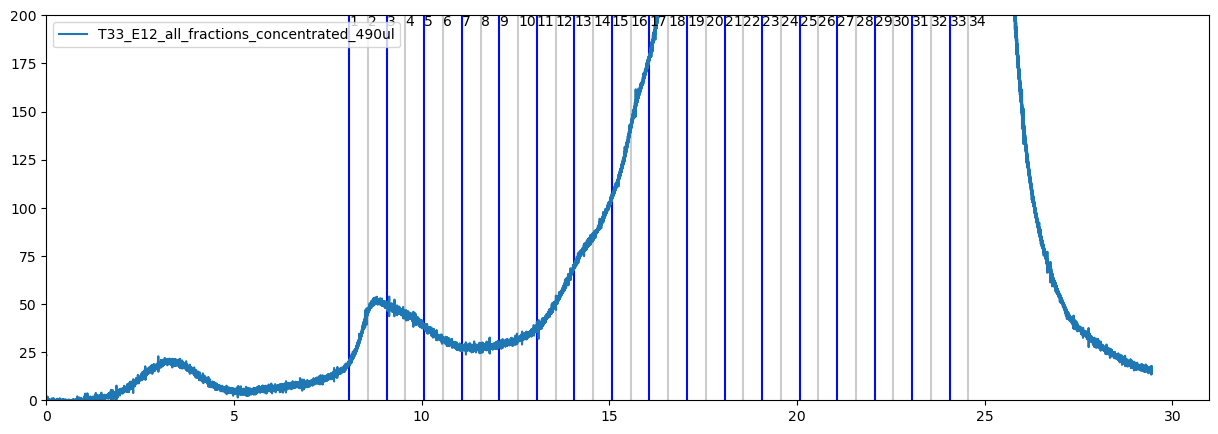

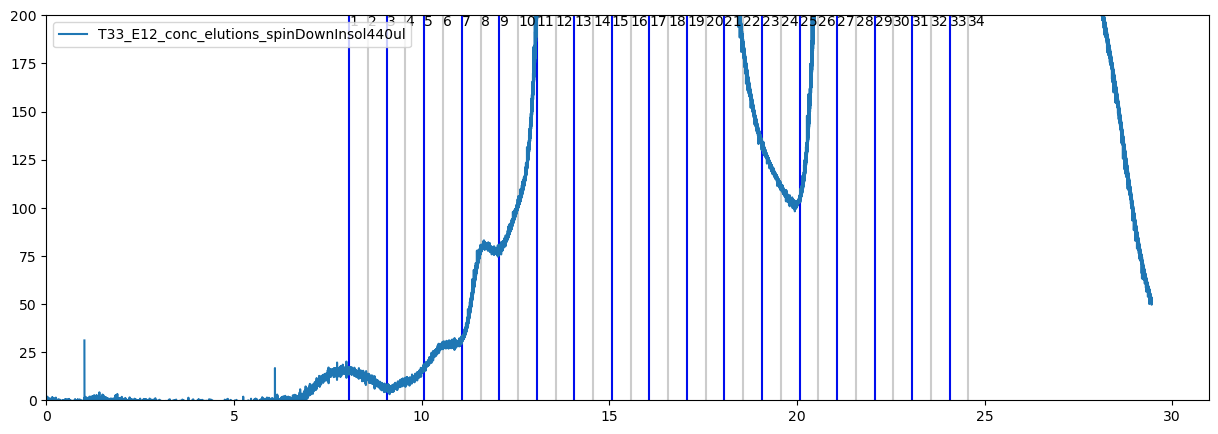

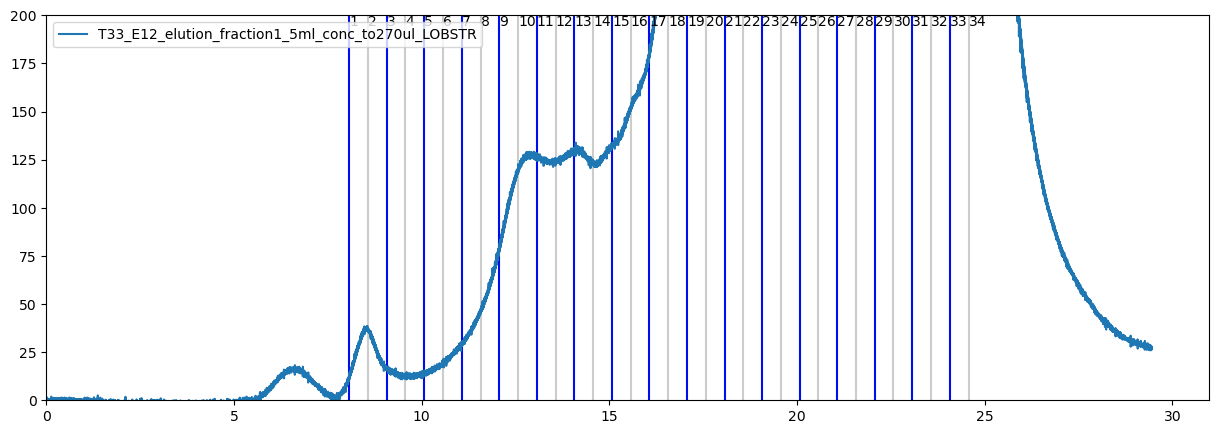

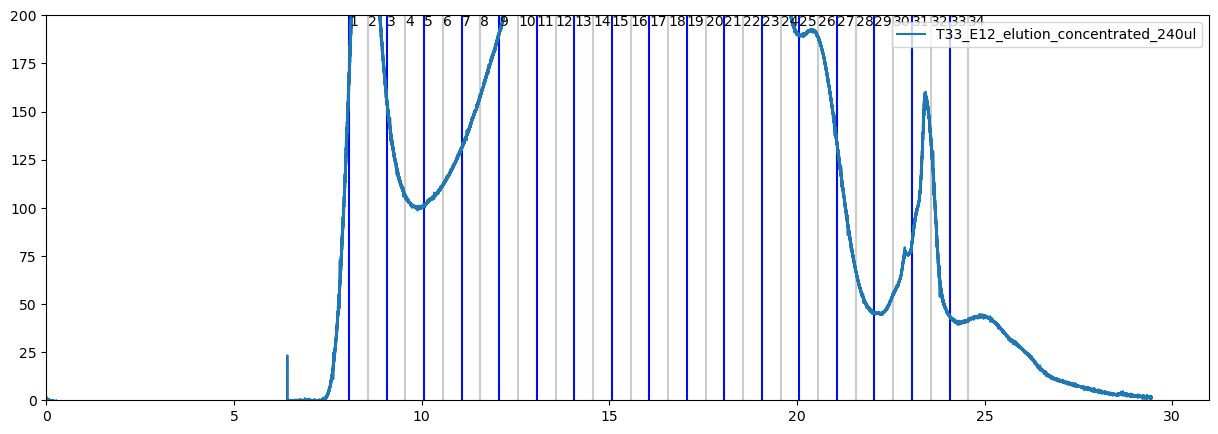

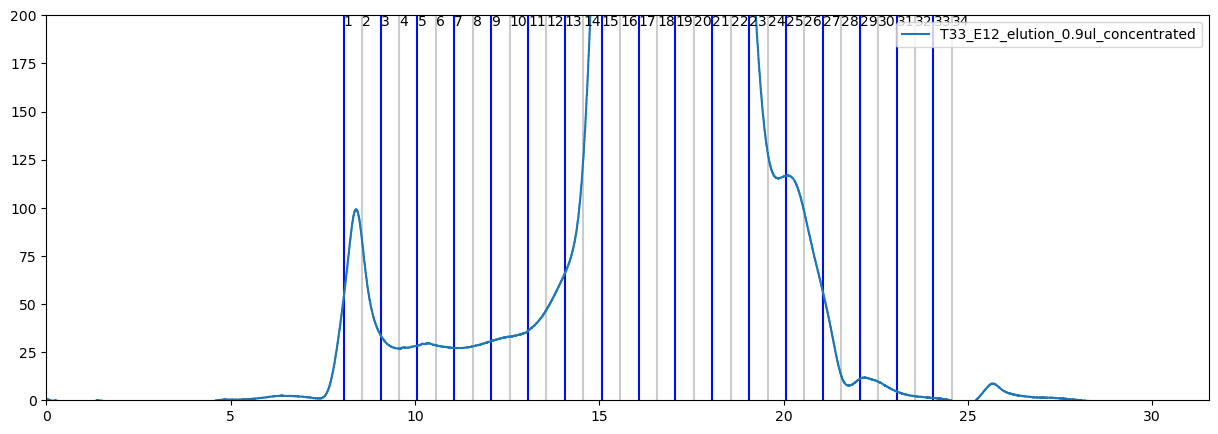

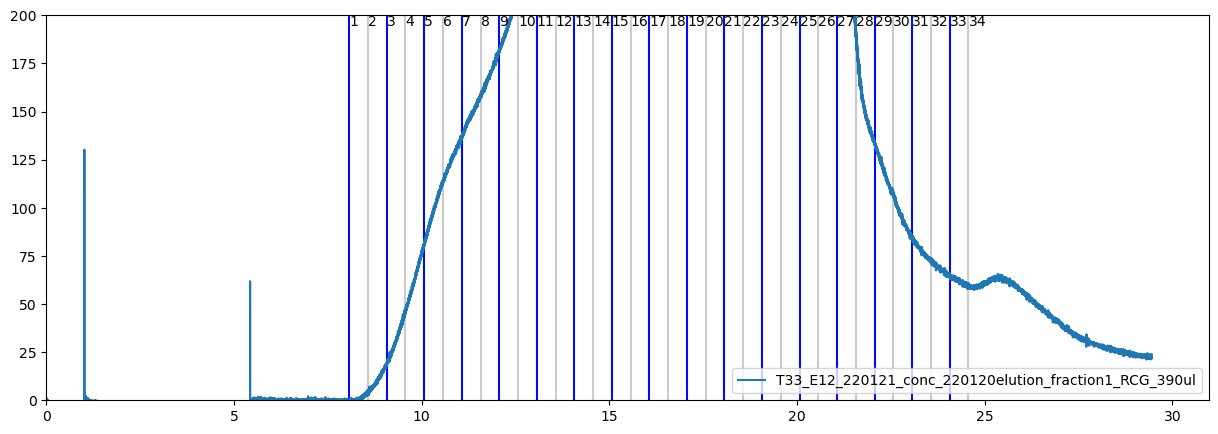

In [51]:
plot_chromatograms(sec_runs, chromatogram_keywords=chromatogram_keywords, only_280=only_plot_A280, 
                   overlap_chromatograms=overlap_chromatograms, stack_figures=stack_figures,
                   volume_is_column= not volume_is_index, fractions=plot_fractions,
                   fraction_start=fraction_start, fraction_end=fraction_end, fraction_size=fraction_size,
                   max_y=max_y, min_y=min_y, max_x=max_x, min_x=min_x,
                  )